In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
import os
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [2]:
nueva_ruta = '/media/erick/TOSHIBA EXT/tests'

In [3]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = 1


# Define mesh and space
nodes_in_xaxis=int(os.getenv('nodes_in_xaxis'))
nodes_in_yaxis=int(os.getenv('nodes_in_yaxis'))
space_size=int(os.getenv('space_size'))


os.chdir(nueva_ruta)

In [4]:
# Parámetros de entrada
field1_name = "c"  # Campo c (cáncer)
field2_name = "s"  # Campo s (células sanas)

In [5]:
def power_spectrum(field_name, t, block):
    """
    Calcula el espectro de potencia 2D en el espacio de Fourier y lo guarda normalizado.
    """
    field_file = f"matrix_{field_name}_{t:.3f}_nb_{block}.txt"
    field = np.loadtxt(field_file, float)
    # field = np.rot90(field, k=1, axes=(0, 1))  # Rotación según necesidad

    # Transformada de Fourier
    fft_field = np.fft.fft2(field)
    fft_field = np.fft.fftshift(fft_field)
    fft_field = np.abs(fft_field)

    # Eliminar la frecuencia cero (componente DC)
    # max_fft = np.where(fft_field == fft_field.max())
    # fft_field[max_fft[0][0], max_fft[1][0]] = 0

    # # Normalización: Dividir por la suma total para asegurar consistencia
    # fft_field /= np.sum(fft_field)

    # # Guardar el espectro de potencia normalizado
    dft_file = f"matrix_{field_name}_dft_{t:.3f}_nb_{block}.txt"
    # np.savetxt(dft_file, fft_field, delimiter="\t")
    return field_file, dft_file

In [6]:
def correlation_function_fourier(dft_field1, dft_field2, field1_name, field2_name, step, block):
    """
    Calcula la correlación cruzada en el espacio de Fourier, sin transformarla al espacio real.

    Args:
        dft_field1 (str): Ruta al archivo con el espectro de Fourier del primer campo.
        dft_field2 (str): Ruta al archivo con el espectro de Fourier del segundo campo.
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        block (int): Número de bloque.

    Returns:
        np.ndarray: Función de correlación en el espacio de Fourier.
    """
    # Cargar los espectros de Fourier
    fft1 = np.loadtxt(dft_field1, delimiter="\t")
    fft2 = np.loadtxt(dft_field2, delimiter="\t")

    # Multiplicar en el dominio de Fourier
    correlation_fourier = fft1 * np.conjugate(fft2)
    
    # Normalización
    # correlation_fourier /= np.max(np.abs(correlation_fourier))
    
    # # Guardar en un archivo txt
    # corr_fourier_file = f"corr_fourier_space_{field1_name}_{field2_name}_{step:.3f}_block_{block}.txt"
    # np.savetxt(corr_fourier_file, np.column_stack((correlation_fourier.real, correlation_fourier.imag)), delimiter="\t", header="Real\tImag", comments="")
    # print(f"Correlación en el espacio de Fourier guardada en {corr_fourier_file}")
    # Aplicar fftshift para centrar el espectro en la imagen
    correlation_fourier_shifted = np.fft.fftshift(correlation_fourier)
    

    plt.figure(figsize=(6, 5))
    plt.imshow(correlation_fourier_shifted, cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitud')
    plt.title(f'Correlación ({field1_name} vs {field2_name}) Fourier')
    plt.xlabel('Frecuencia X')
    plt.ylabel('Frecuencia Y')
    plt.show()

    return correlation_fourier

In [7]:

def inverse_correlation_fft(centered_correlation, field1_name, field2_name, step, block):
    """
    Revierte el desplazamiento de la función de correlación en Fourier y la transforma de vuelta al espacio real.

    Args:
        centered_correlation (np.ndarray): Función de correlación en el espacio de Fourier.
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        block (int): Número de bloque.

    Returns:
        np.ndarray: Transformada inversa de la correlación en el espacio real.
    """
    # Aplicar la transformada inversa de Fourier
    inverse_fft = np.fft.ifft2(centered_correlation).real  # Obtener solo la parte real
    
    # Volver a centrar la matriz
    centered_inverse_fft = np.fft.fftshift(inverse_fft)

    # Verificar valores antes de normalizar
    min_val = np.min(centered_inverse_fft)
    max_val = np.max(centered_inverse_fft)
    
    # Normalizar entre 0 y 1
    centered_inverse_fft -= min_val  # Asegurar que el mínimo sea 0
    centered_inverse_fft /= (max_val - min_val + 1e-8)  # Normalizar evitando división por 0

    # Graficar la transformada inversa centrada
    plt.figure(figsize=(6, 5))
    plt.imshow(centered_inverse_fft, cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitud')
    plt.title(f'Correlación ({field1_name} vs {field2_name}) real')
    plt.xlabel('Índice X')
    plt.ylabel('Índice Y')
    plt.show()
    
    return centered_inverse_fft

In [8]:
def compute_correlation_length(centered_inverse_fft, dx=0.35):
    """
    Calcula la longitud de correlación a partir de un promedio radial de la transformada inversa centrada.
    
    Args:
        centered_inverse_fft (np.ndarray): Transformada inversa de la correlación centrada.
        dx (float): Resolución espacial en unidades físicas.
    
    Returns:
        float: Longitud de correlación en unidades físicas.
    """
    ny, nx = centered_inverse_fft.shape
    x_center, y_center = nx // 2, ny // 2
    
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2).astype(int)
    
    r_max = r.max()
    radial_profile = np.zeros(r_max + 1)
    counts = np.zeros(r_max + 1)
    
    for i in range(ny):
        for j in range(nx):
            radial_profile[r[i, j]] += centered_inverse_fft[i, j]
            counts[r[i, j]] += 1
    
    radial_profile /= np.where(counts == 0, 1, counts)
    
    max_value = radial_profile[0]
    threshold = max_value / np.e
    correlation_length_pixels = np.argmax(radial_profile < threshold)
    
    correlation_length_real = correlation_length_pixels * dx  # Conversión a unidades físicas
    
    print('Longitud de correlación en píxeles:', correlation_length_pixels)
    print('Longitud de correlación en unidades reales:', correlation_length_real)
    
    return correlation_length_real


block= 1 tiempo 0


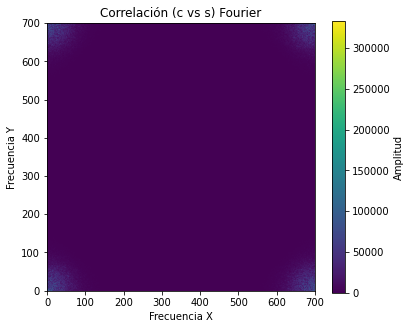

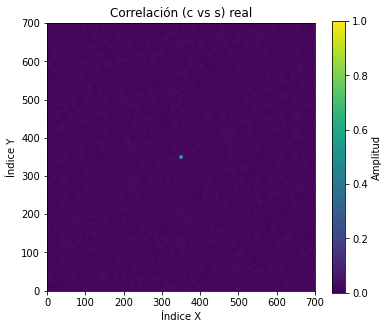

Longitud de correlación en píxeles: 4
Longitud de correlación en unidades reales: 1.4
block= 1 tiempo 0.005


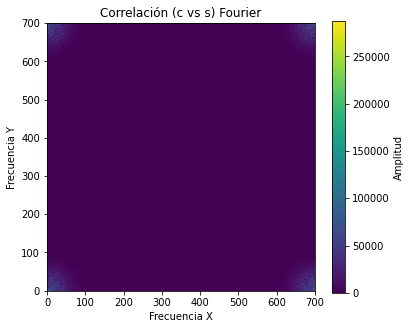

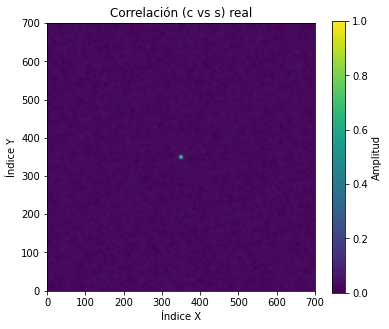

Longitud de correlación en píxeles: 5
Longitud de correlación en unidades reales: 1.75
block= 1 tiempo 0.01


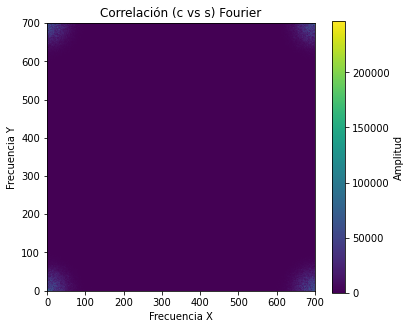

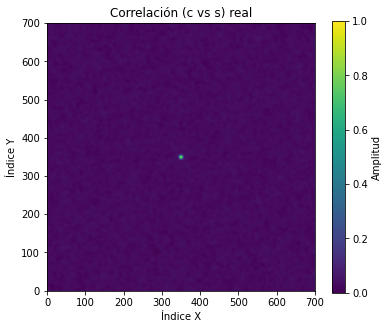

Longitud de correlación en píxeles: 5
Longitud de correlación en unidades reales: 1.75
block= 1 tiempo 0.015


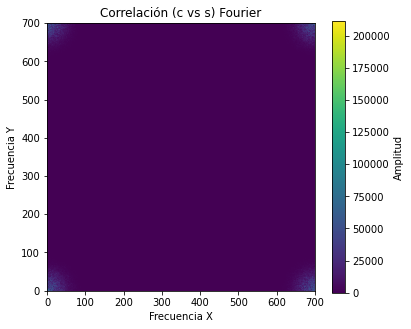

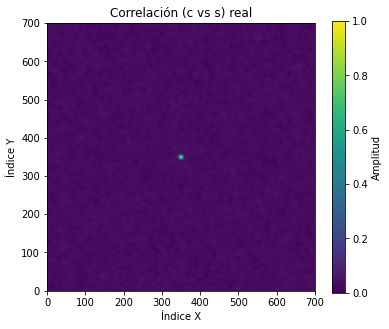

Longitud de correlación en píxeles: 5
Longitud de correlación en unidades reales: 1.75
block= 1 tiempo 0.02


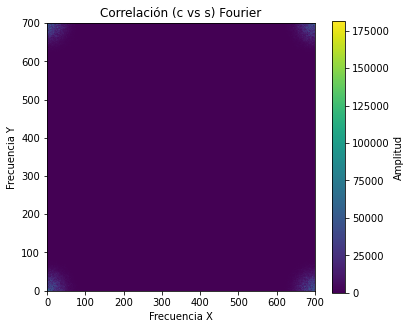

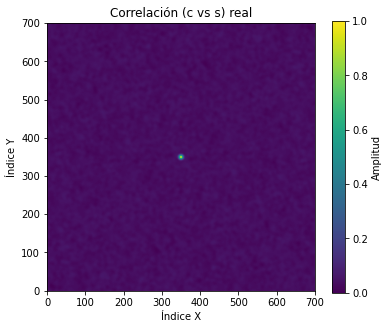

Longitud de correlación en píxeles: 6
Longitud de correlación en unidades reales: 2.0999999999999996
block= 1 tiempo 0.025


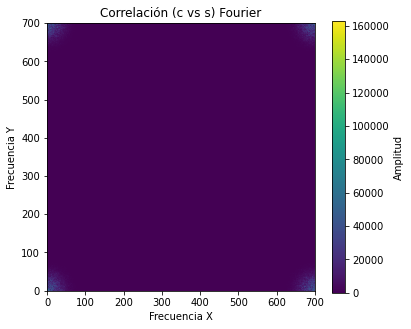

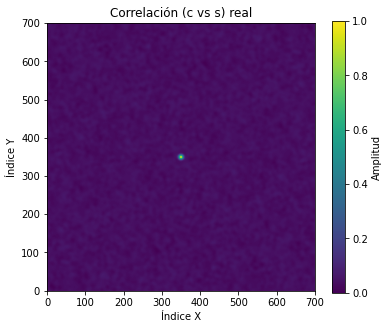

Longitud de correlación en píxeles: 6
Longitud de correlación en unidades reales: 2.0999999999999996
block= 1 tiempo 0.030000000000000002


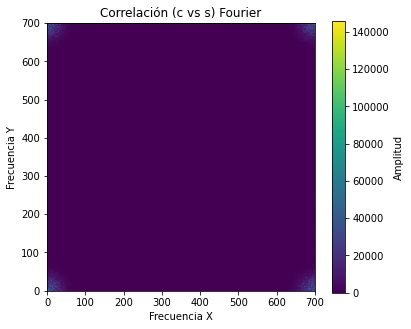

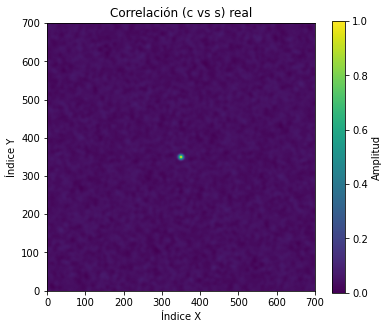

Longitud de correlación en píxeles: 7
Longitud de correlación en unidades reales: 2.4499999999999997
block= 1 tiempo 0.035


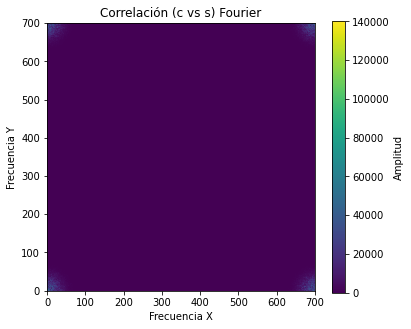

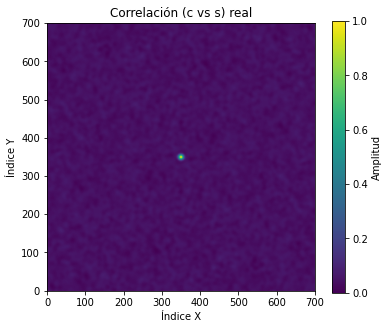

Longitud de correlación en píxeles: 7
Longitud de correlación en unidades reales: 2.4499999999999997
block= 1 tiempo 0.04


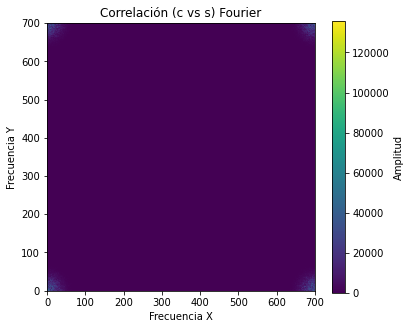

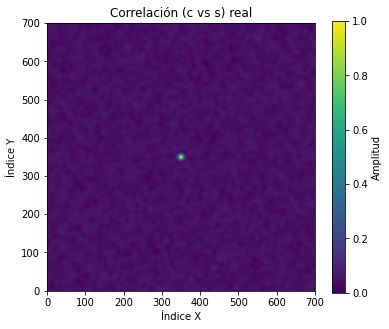

Longitud de correlación en píxeles: 7
Longitud de correlación en unidades reales: 2.4499999999999997
block= 1 tiempo 0.045


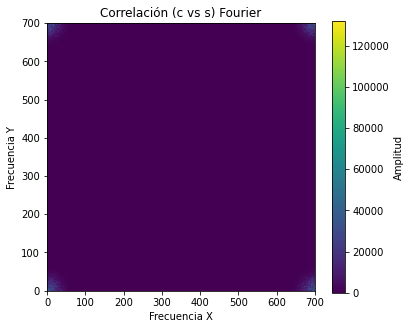

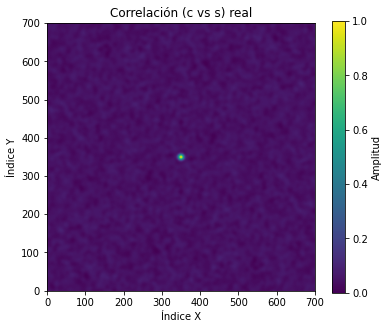

Longitud de correlación en píxeles: 8
Longitud de correlación en unidades reales: 2.8
block= 1 tiempo 0.049999999999999996


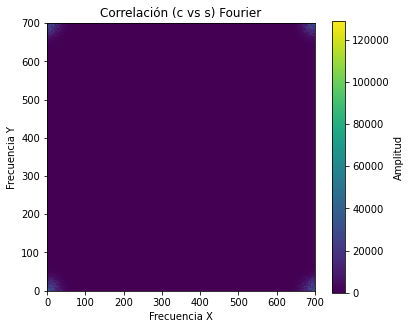

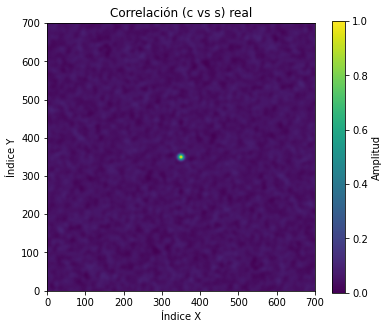

Longitud de correlación en píxeles: 8
Longitud de correlación en unidades reales: 2.8
block= 1 tiempo 0.05499999999999999


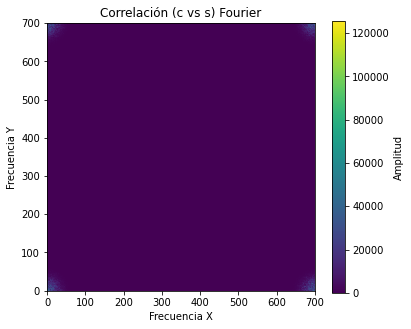

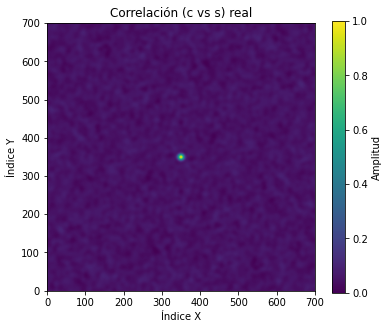

Longitud de correlación en píxeles: 8
Longitud de correlación en unidades reales: 2.8
block= 1 tiempo 0.05999999999999999


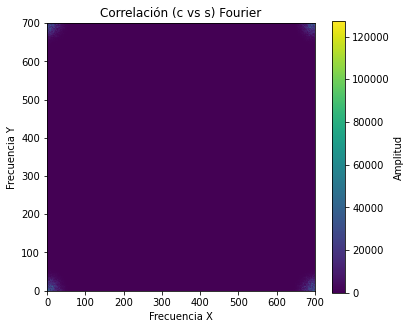

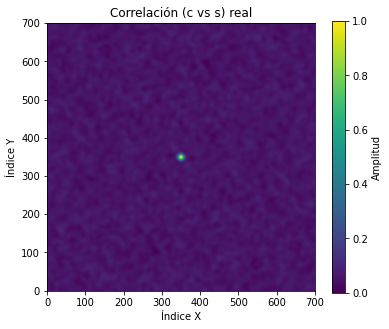

Longitud de correlación en píxeles: 9
Longitud de correlación en unidades reales: 3.15
block= 1 tiempo 0.06499999999999999


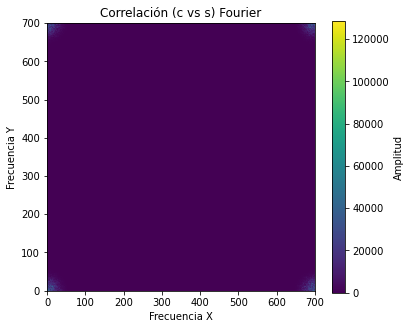

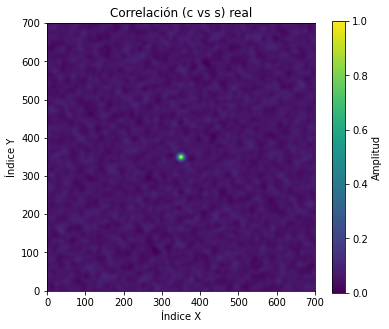

Longitud de correlación en píxeles: 9
Longitud de correlación en unidades reales: 3.15
block= 1 tiempo 0.06999999999999999


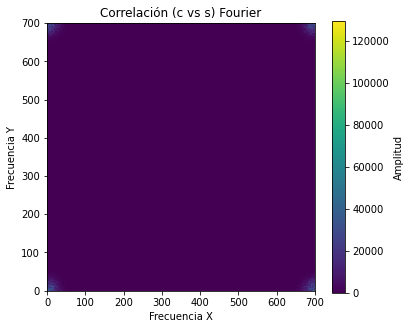

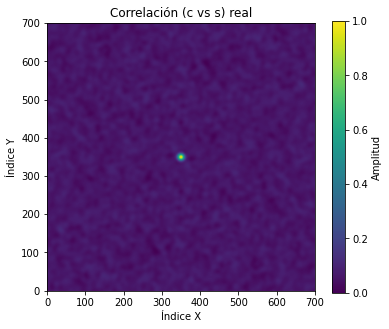

Longitud de correlación en píxeles: 9
Longitud de correlación en unidades reales: 3.15
block= 1 tiempo 0.075


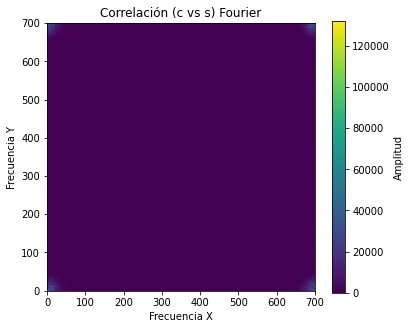

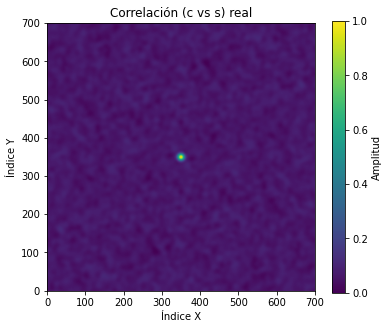

Longitud de correlación en píxeles: 9
Longitud de correlación en unidades reales: 3.15
block= 1 tiempo 0.08


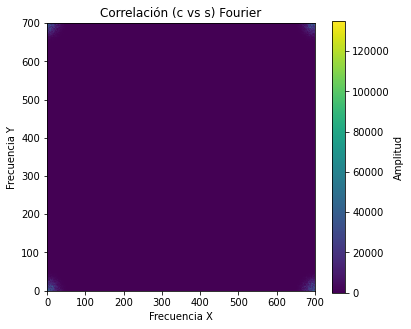

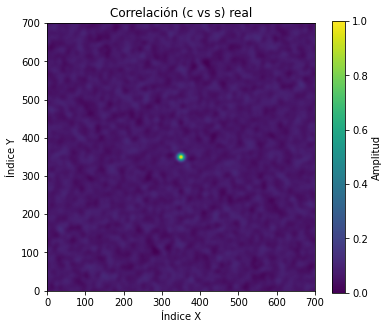

Longitud de correlación en píxeles: 10
Longitud de correlación en unidades reales: 3.5
block= 1 tiempo 0.085


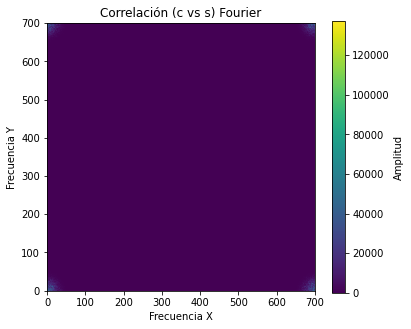

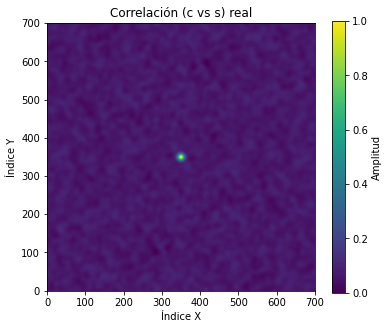

Longitud de correlación en píxeles: 10
Longitud de correlación en unidades reales: 3.5
block= 1 tiempo 0.09000000000000001


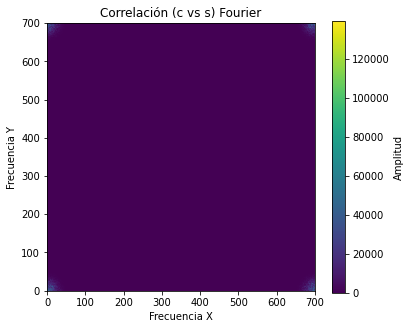

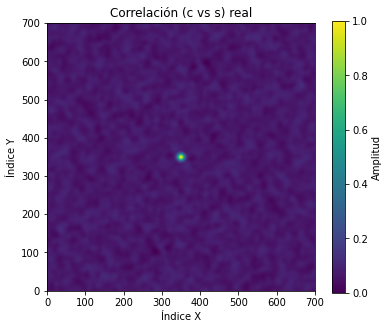

Longitud de correlación en píxeles: 10
Longitud de correlación en unidades reales: 3.5
block= 1 tiempo 0.09500000000000001


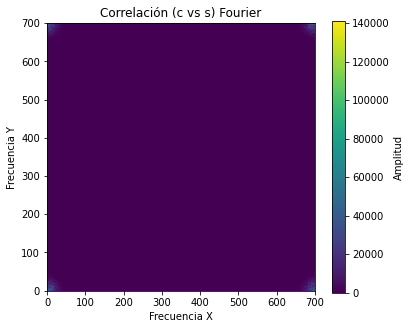

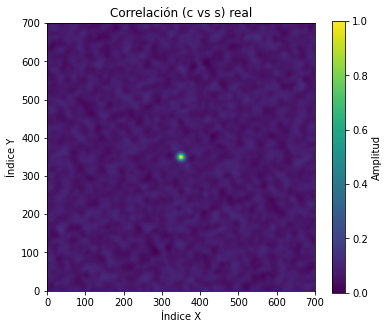

Longitud de correlación en píxeles: 10
Longitud de correlación en unidades reales: 3.5
block= 1 tiempo 0.10000000000000002


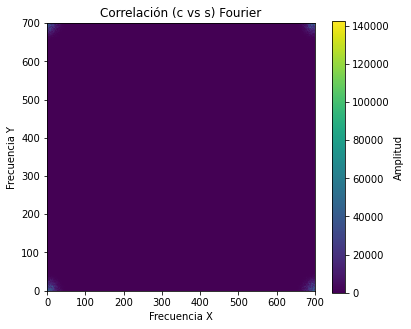

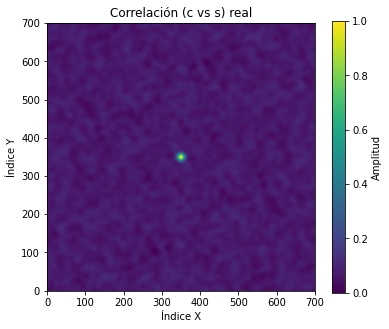

Longitud de correlación en píxeles: 11
Longitud de correlación en unidades reales: 3.8499999999999996
block= 1 tiempo 0.10500000000000002


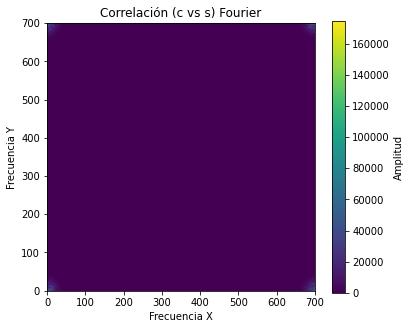

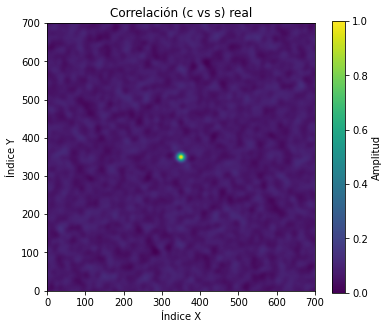

Longitud de correlación en píxeles: 11
Longitud de correlación en unidades reales: 3.8499999999999996
block= 1 tiempo 0.11000000000000003


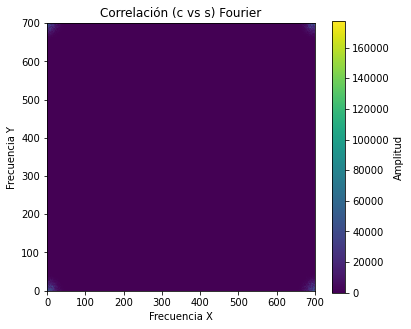

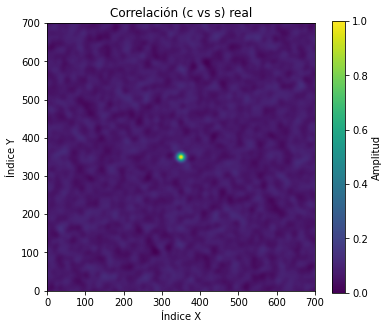

Longitud de correlación en píxeles: 11
Longitud de correlación en unidades reales: 3.8499999999999996
block= 1 tiempo 0.11500000000000003


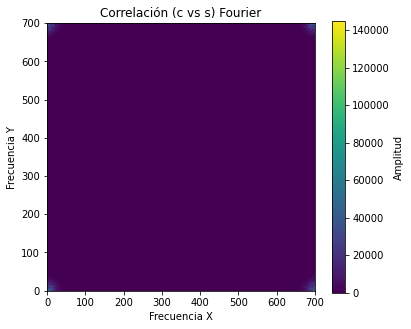

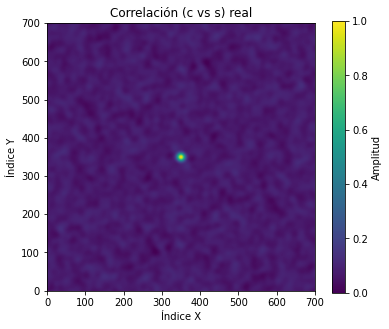

Longitud de correlación en píxeles: 11
Longitud de correlación en unidades reales: 3.8499999999999996
block= 1 tiempo 0.12000000000000004


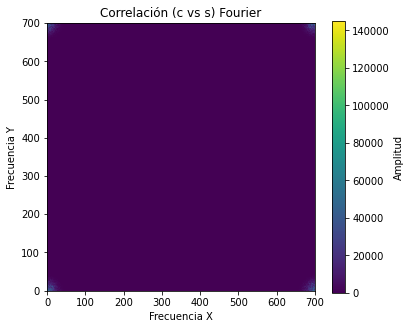

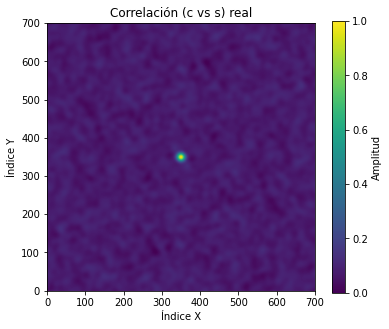

Longitud de correlación en píxeles: 11
Longitud de correlación en unidades reales: 3.8499999999999996
block= 1 tiempo 0.12500000000000003


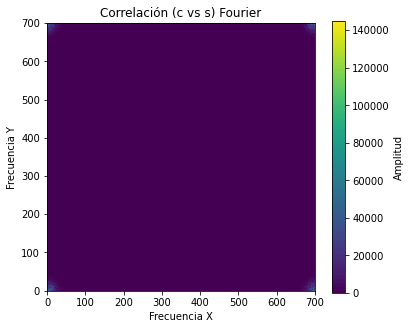

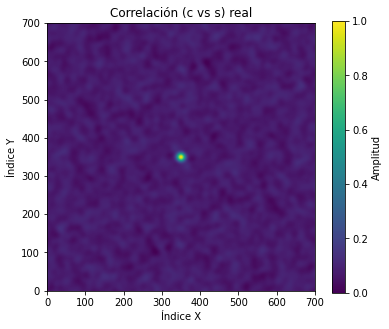

Longitud de correlación en píxeles: 12
Longitud de correlación en unidades reales: 4.199999999999999
block= 1 tiempo 0.13000000000000003


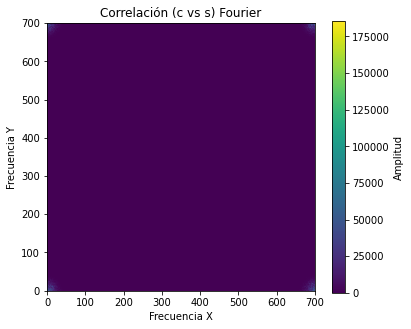

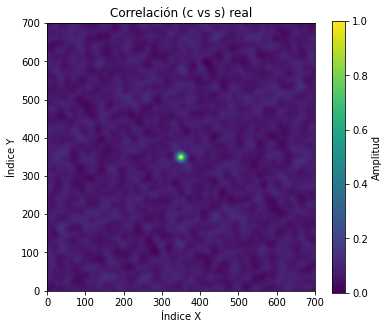

Longitud de correlación en píxeles: 12
Longitud de correlación en unidades reales: 4.199999999999999
block= 1 tiempo 0.13500000000000004


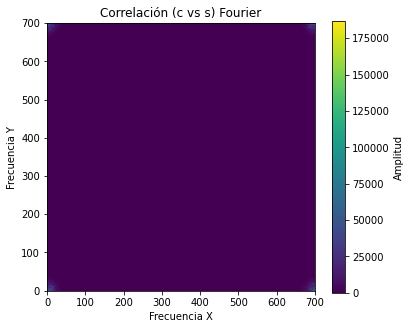

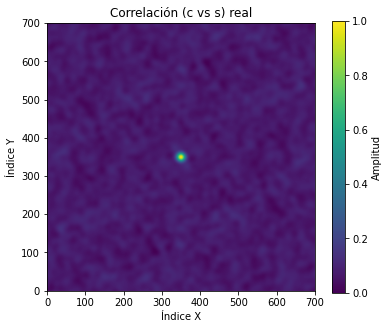

Longitud de correlación en píxeles: 12
Longitud de correlación en unidades reales: 4.199999999999999
block= 1 tiempo 0.14000000000000004


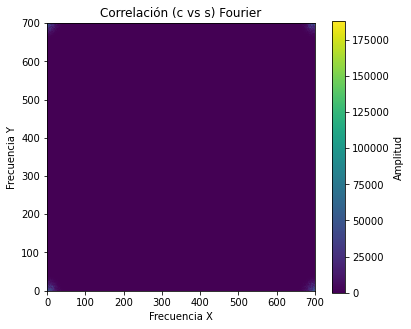

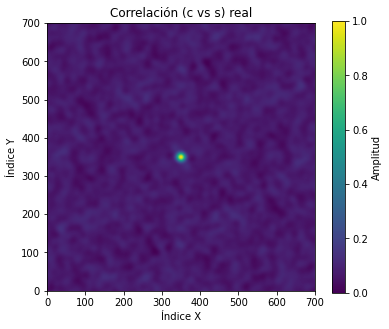

Longitud de correlación en píxeles: 12
Longitud de correlación en unidades reales: 4.199999999999999
block= 1 tiempo 0.14500000000000005


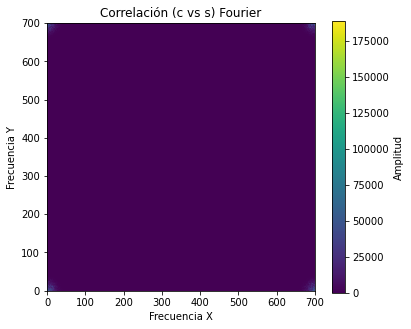

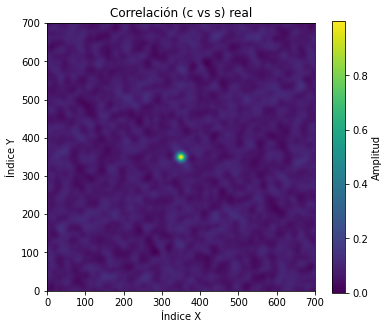

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.15000000000000005


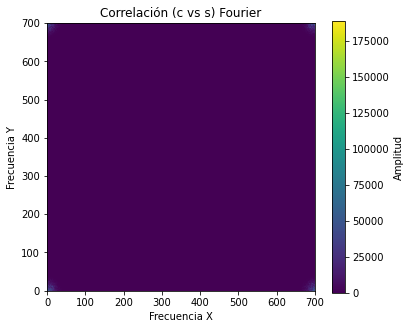

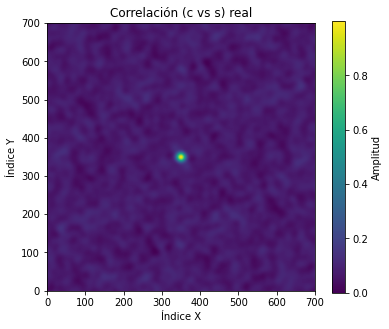

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.15500000000000005


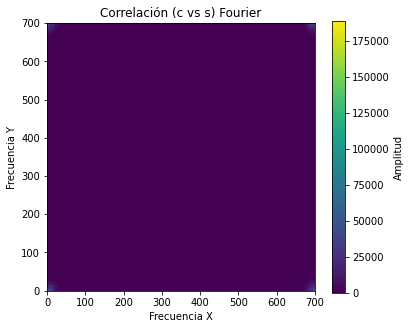

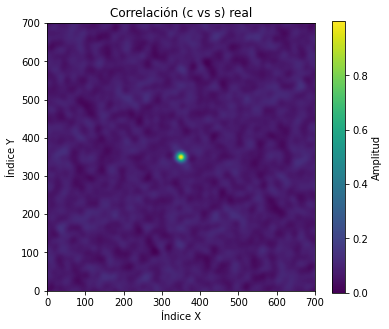

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.16000000000000006


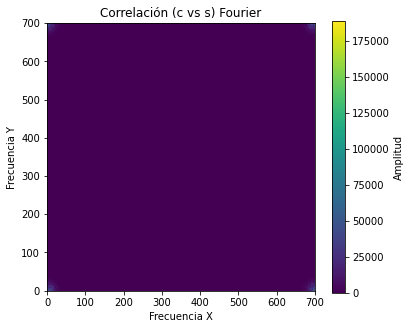

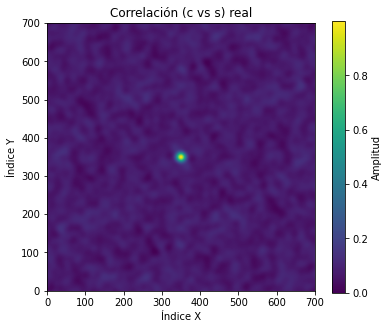

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.16500000000000006


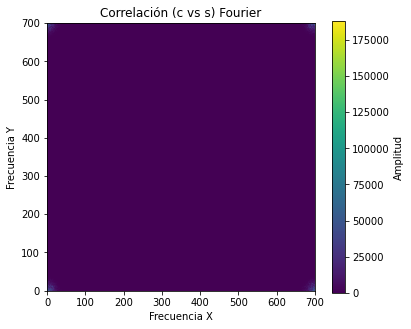

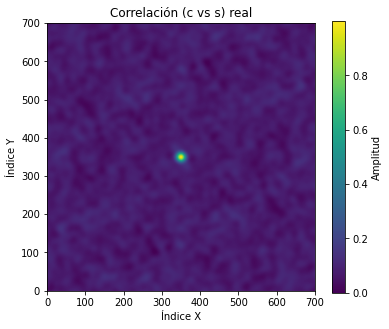

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.17000000000000007


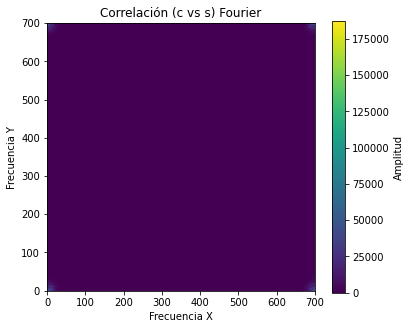

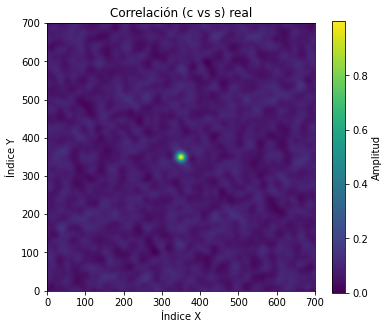

Longitud de correlación en píxeles: 13
Longitud de correlación en unidades reales: 4.55
block= 1 tiempo 0.17500000000000007


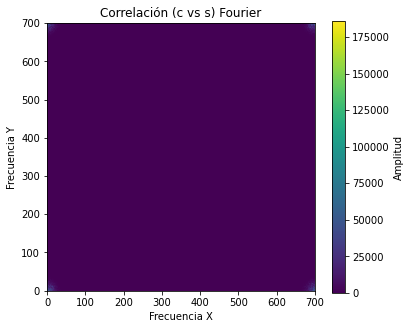

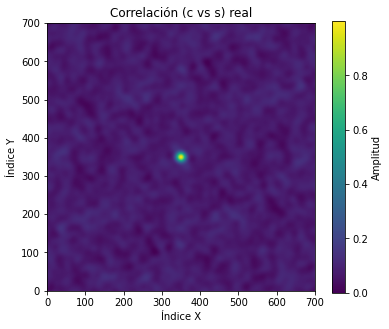

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.18000000000000008


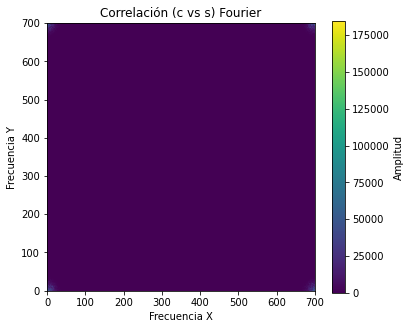

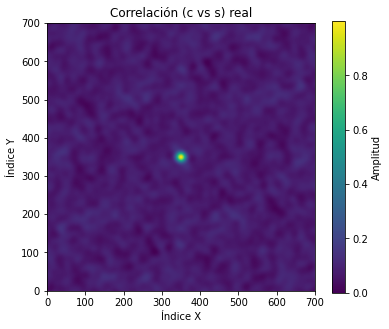

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.18500000000000008


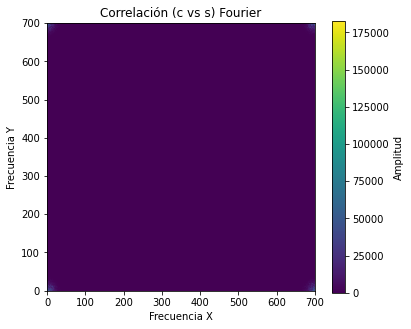

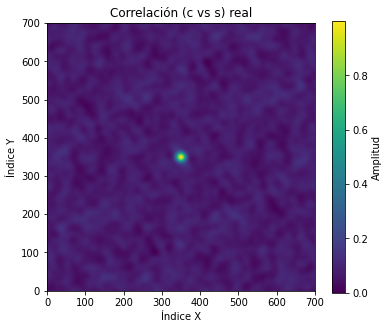

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.19000000000000009


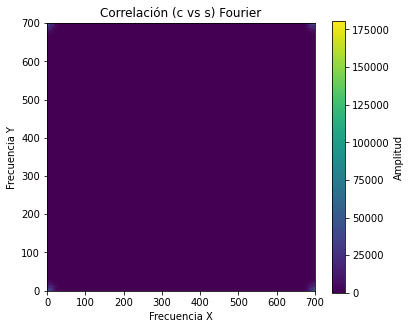

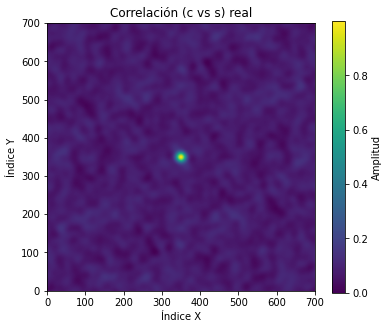

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.1950000000000001


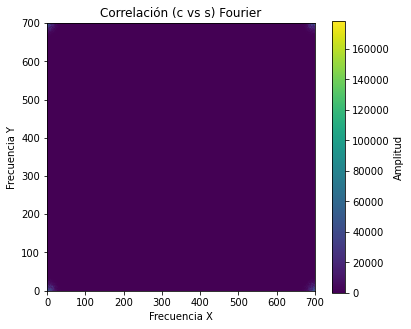

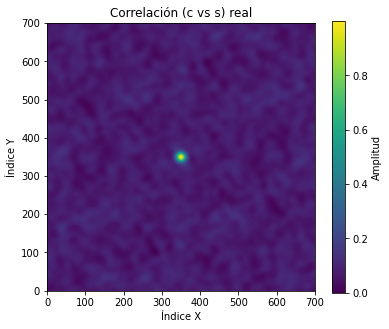

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.2000000000000001


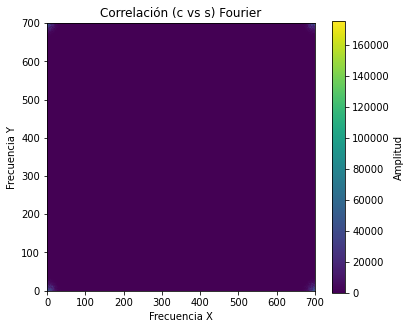

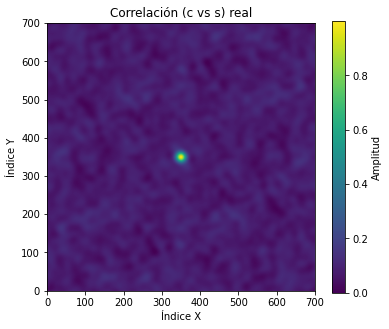

Longitud de correlación en píxeles: 14
Longitud de correlación en unidades reales: 4.8999999999999995
block= 1 tiempo 0.2050000000000001


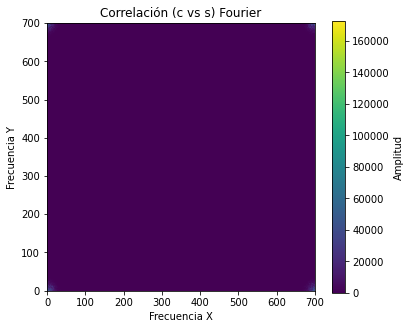

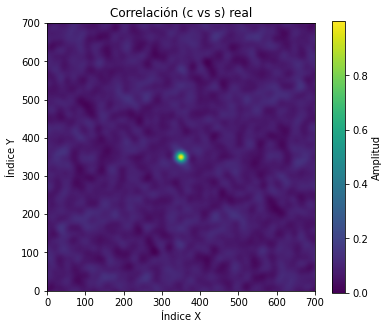

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.2100000000000001


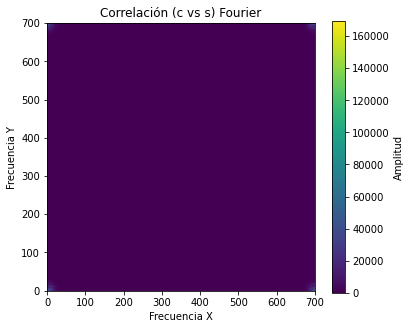

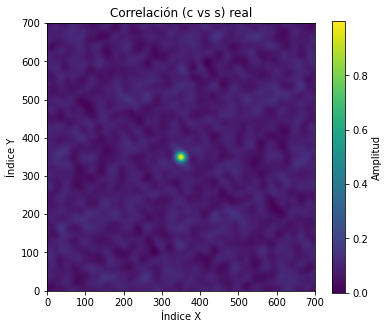

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.2150000000000001


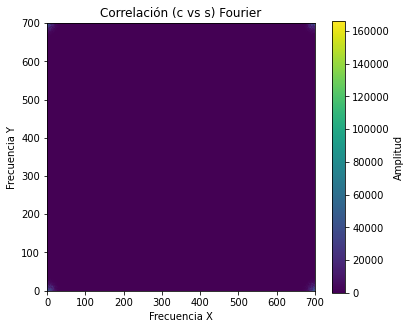

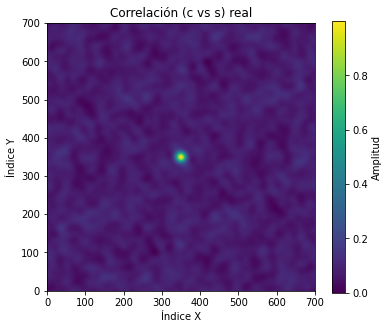

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.2200000000000001


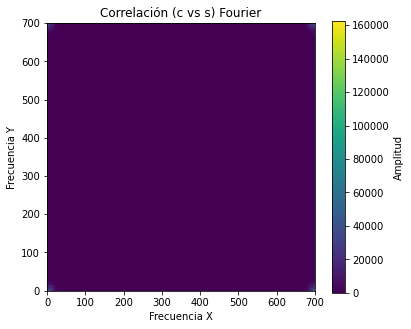

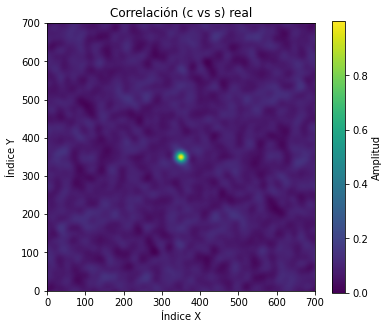

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.22500000000000012


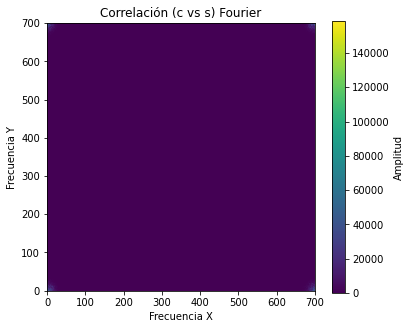

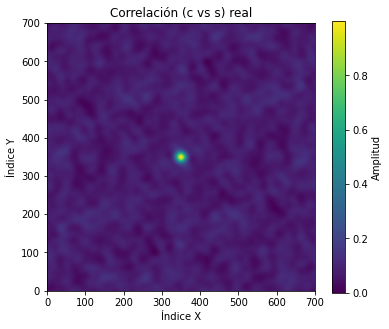

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.23000000000000012


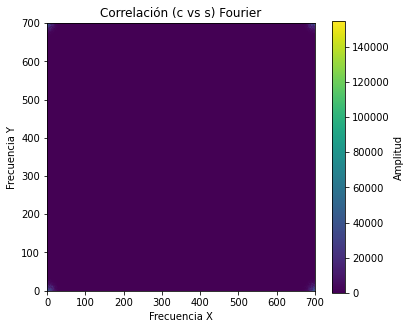

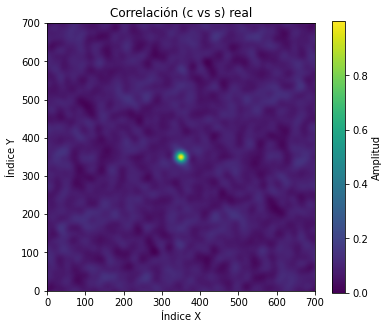

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.23500000000000013


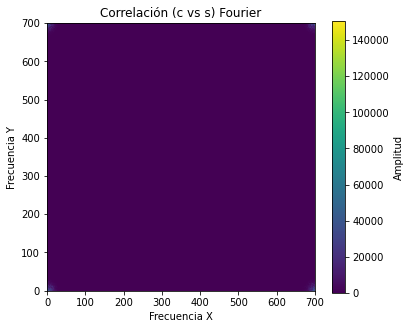

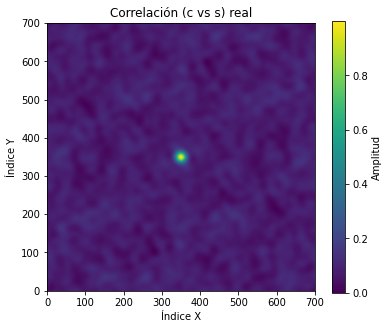

Longitud de correlación en píxeles: 15
Longitud de correlación en unidades reales: 5.25
block= 1 tiempo 0.24000000000000013


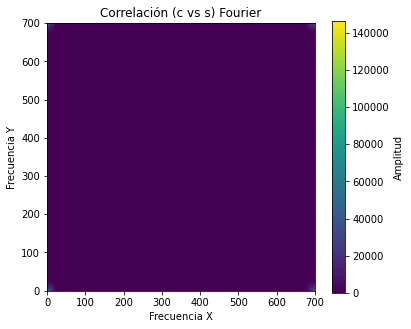

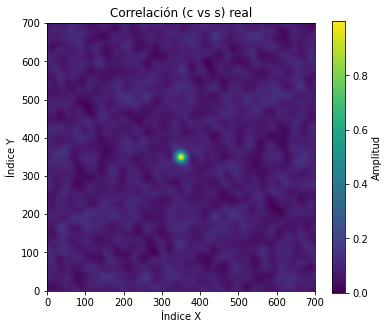

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.24500000000000013


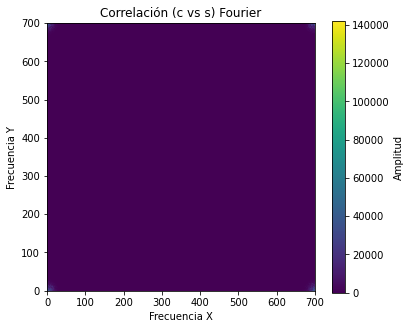

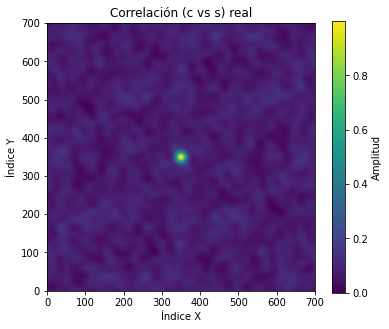

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.2500000000000001


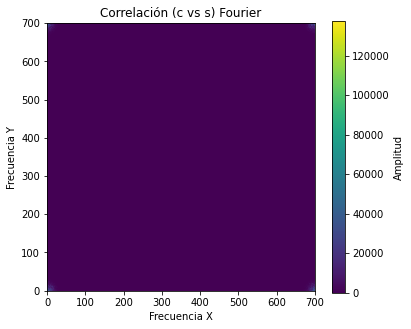

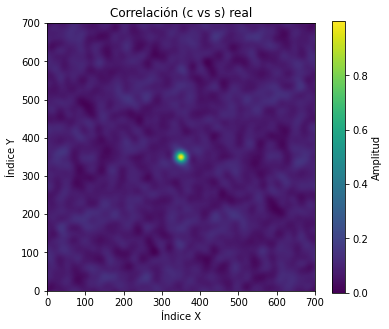

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.2550000000000001


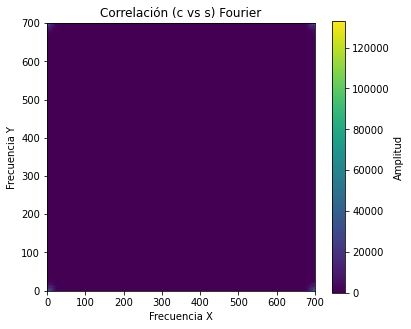

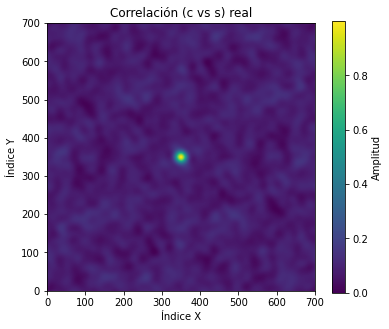

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.2600000000000001


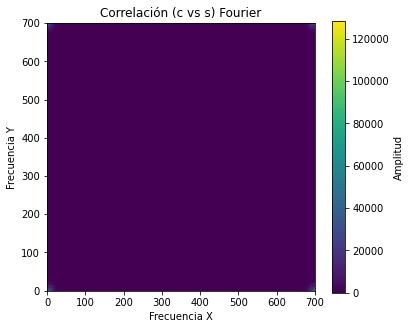

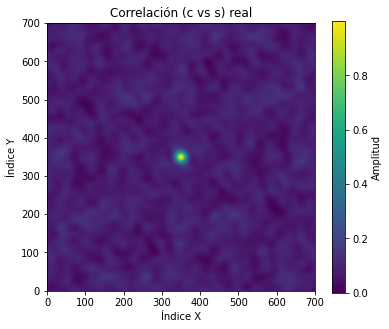

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.2650000000000001


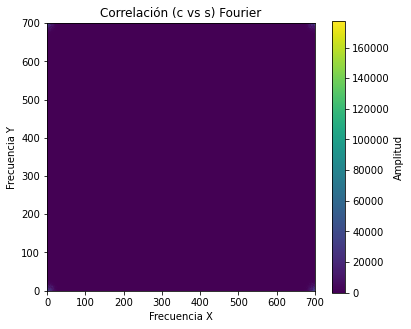

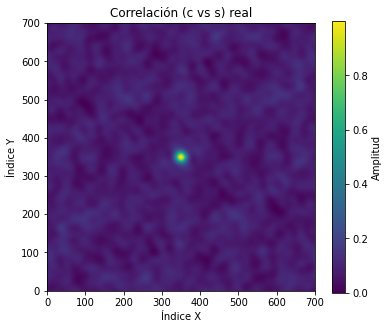

Longitud de correlación en píxeles: 16
Longitud de correlación en unidades reales: 5.6
block= 1 tiempo 0.27000000000000013


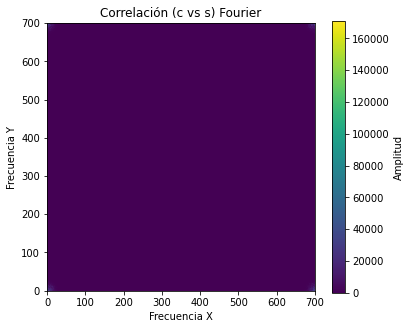

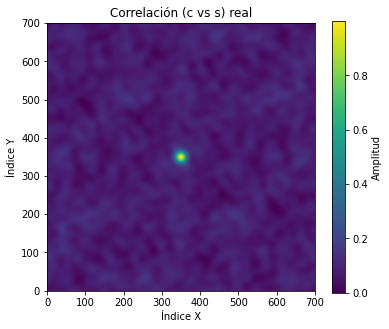

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.27500000000000013


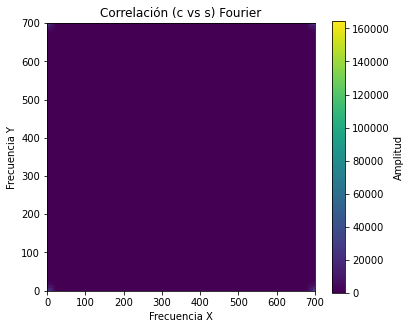

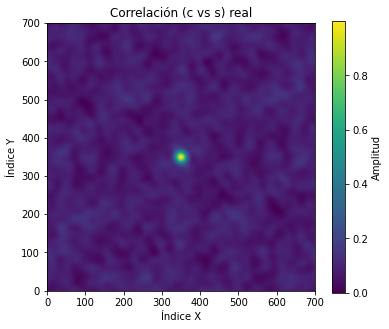

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.28000000000000014


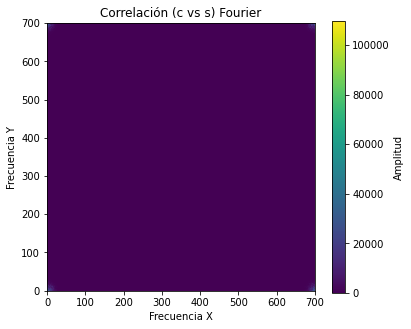

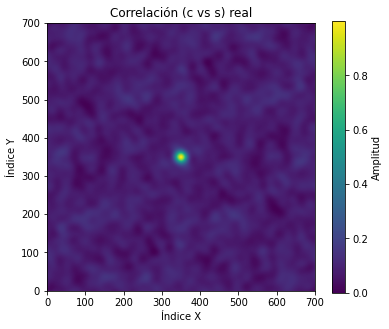

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.28500000000000014


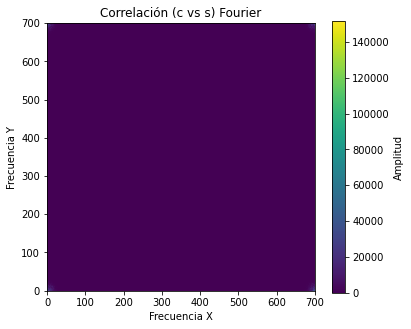

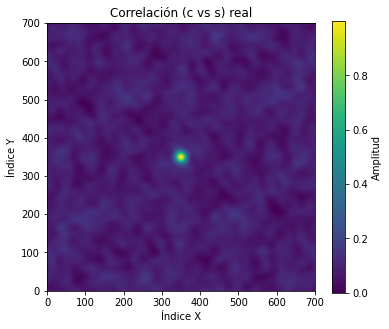

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.29000000000000015


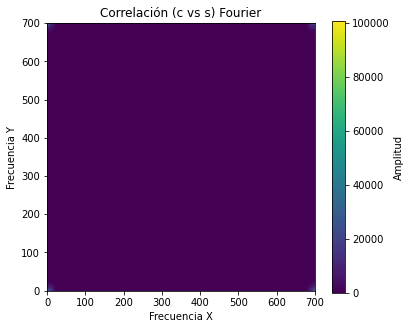

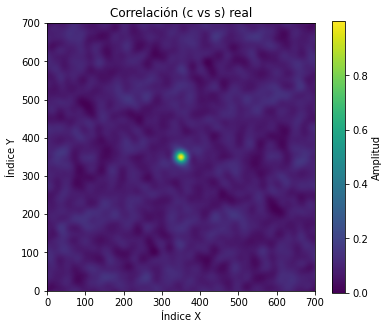

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.29500000000000015


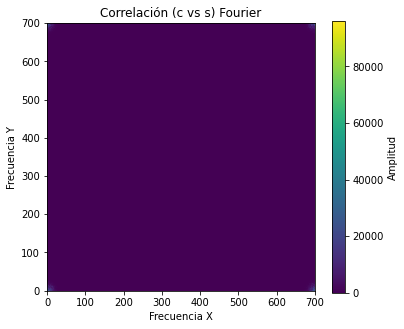

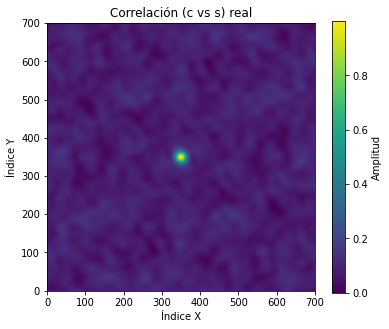

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.30000000000000016


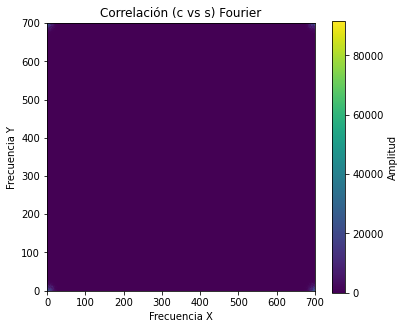

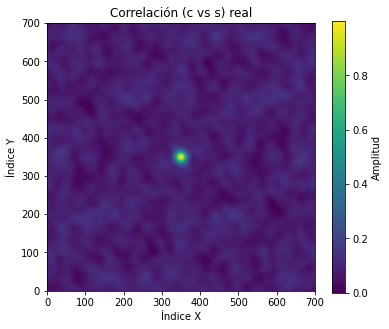

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.30500000000000016


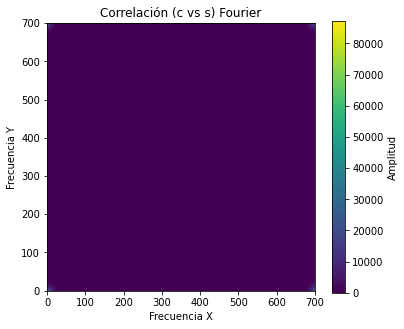

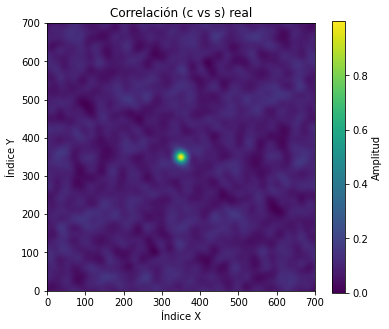

Longitud de correlación en píxeles: 17
Longitud de correlación en unidades reales: 5.949999999999999
block= 1 tiempo 0.31000000000000016


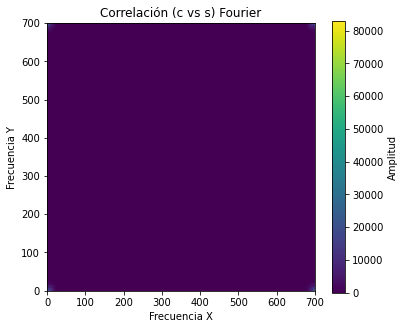

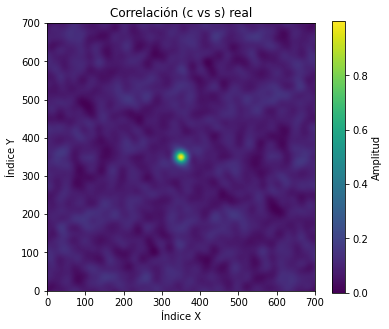

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.31500000000000017


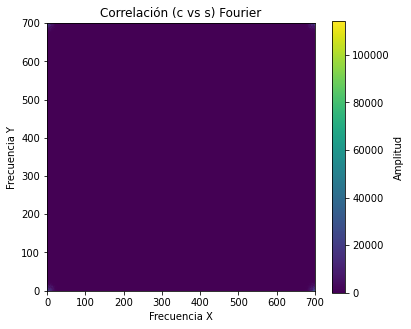

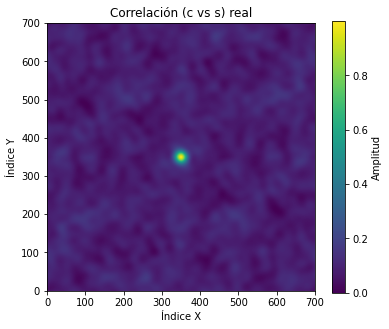

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3200000000000002


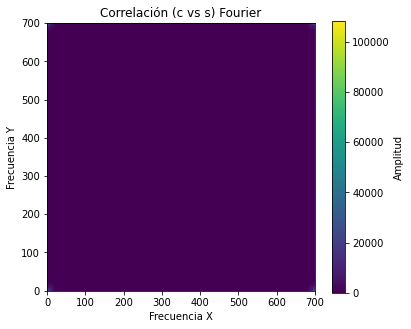

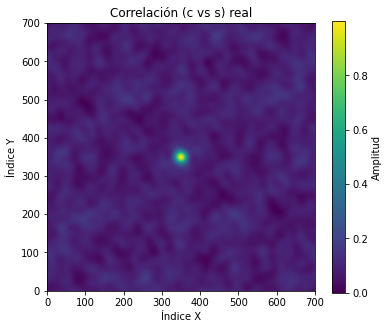

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3250000000000002


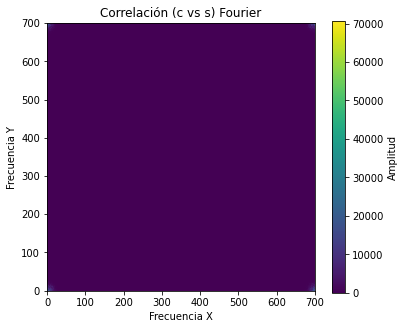

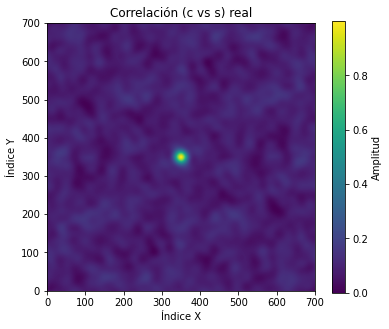

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3300000000000002


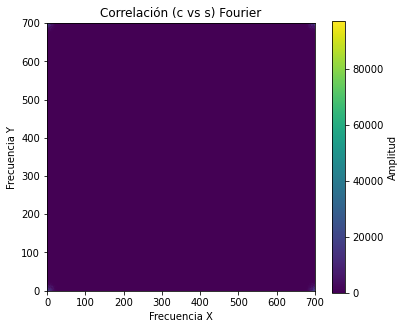

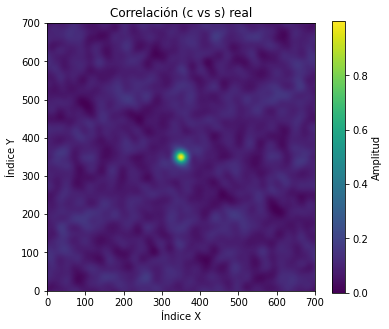

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3350000000000002


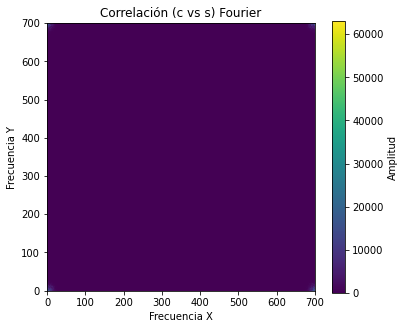

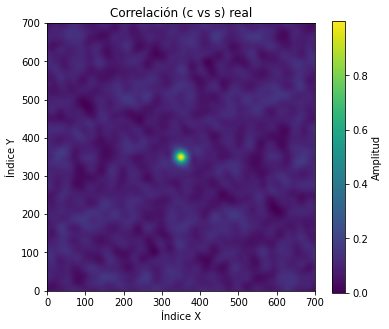

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3400000000000002


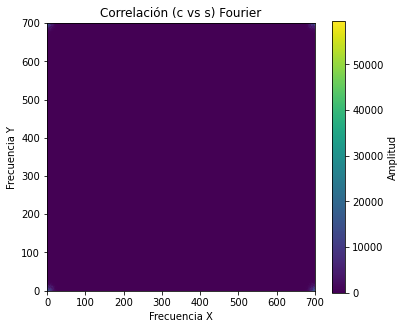

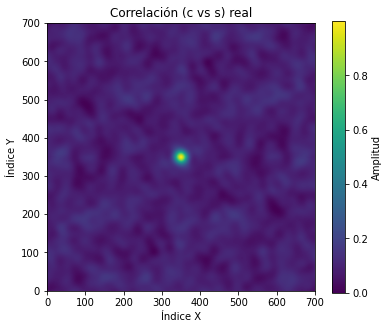

Longitud de correlación en píxeles: 18
Longitud de correlación en unidades reales: 6.3
block= 1 tiempo 0.3450000000000002


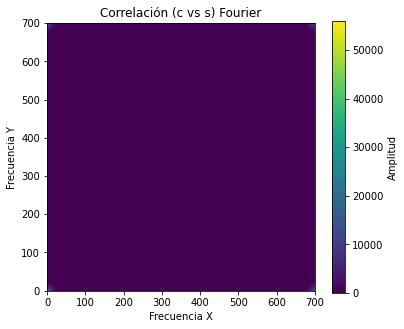

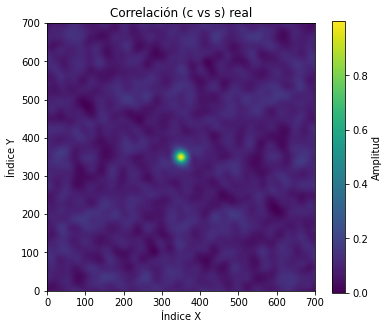

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3500000000000002


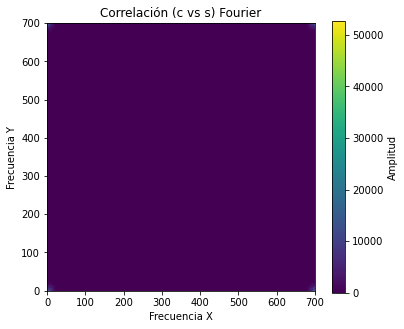

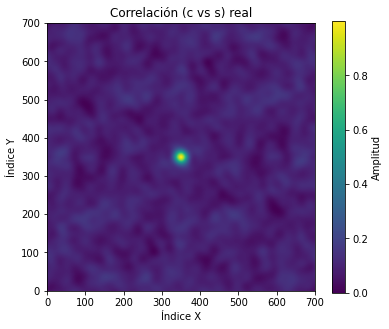

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3550000000000002


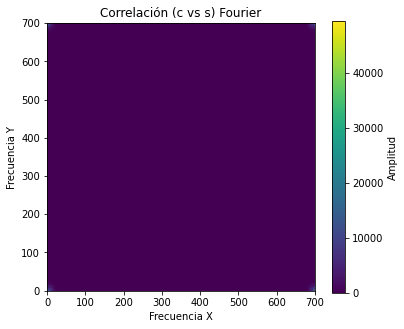

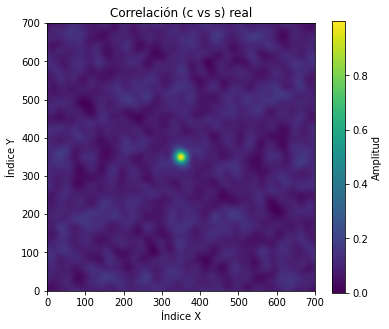

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3600000000000002


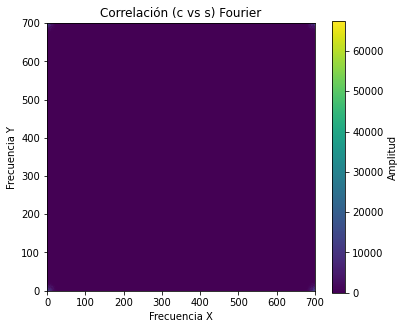

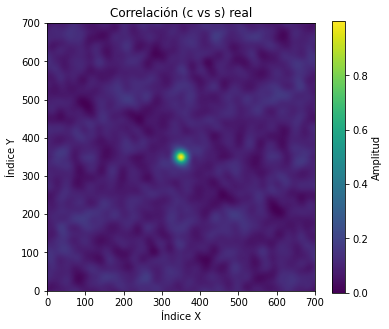

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3650000000000002


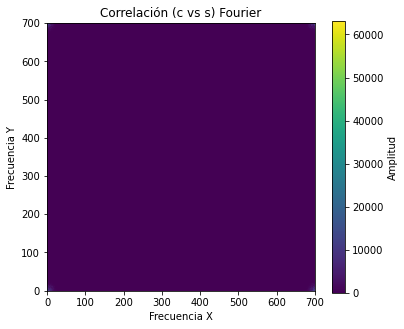

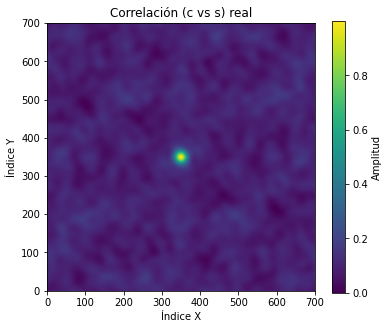

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3700000000000002


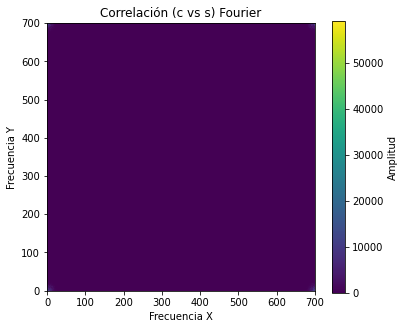

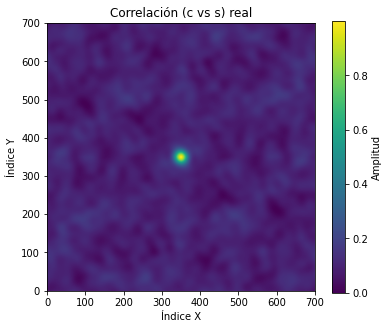

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3750000000000002


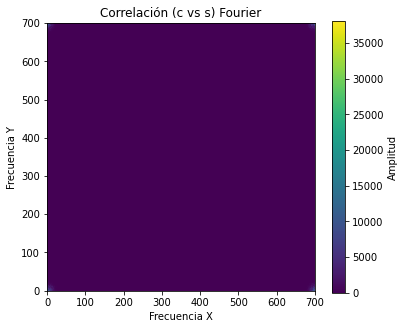

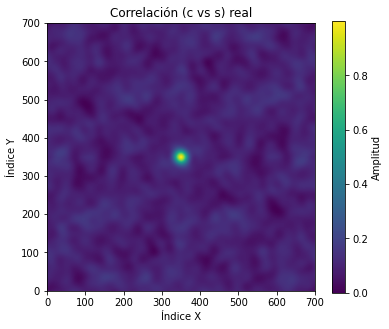

Longitud de correlación en píxeles: 19
Longitud de correlación en unidades reales: 6.6499999999999995
block= 1 tiempo 0.3800000000000002


In [ ]:
dx = space_size / nodes_in_xaxis  # Resolución espacial
length_corr = []

for block in range(1, nb + 1):
    t = 0
    while t <= T:
        print("block=", block, 'tiempo', t)
        field_c, dft_field_c = power_spectrum('c', t, block)
        field_s, dft_field_s = power_spectrum('s', t, block)

        correlation_func = correlation_function_fourier(dft_field_c, dft_field_s, 'c', 's', t, block)
        inverse_fft_real = inverse_correlation_fft(correlation_func, 'c', 's', t, block)
        
        correlation_length = compute_correlation_length(inverse_fft_real, dx)
        length_corr.append([t, correlation_length])
        
        t += dt

length_corr = np.array(length_corr)
np.savetxt(
    f'corr_length_real_inverse_c_s.txt',
    length_corr,
    fmt="%.5f",  # Mayor precisión
    delimiter="\t",
    header="Tiempo\tLongitud_Correlacion"
)

In [ ]:
centered_correlation

In [ ]:
inverse_fft_real